In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
import json
from VSS_COS import VSSParam, VSSPricerCOS
from VSS_Sim import VolterraSteinSteinSimulator
from BS_IV import IV_newton

In [2]:
def plot_implied_vol(ax, Stock, strike, price_mkt, price_model, r, tau, n):

    iv_mkt_call = [IV_newton(p, Stock, K, tau, r, 0, 'call') for K, p in zip(strike['call'], price_mkt['call'])]
    iv_model_call = [IV_newton(p, Stock, K, tau, r, 0, 'call') for K, p in zip(strike['call'], price_model['call'])]
    iv_mkt_put = [IV_newton(p, Stock, K, tau, r, 0, 'put') for K, p in zip(strike['put'], price_mkt['put'])]
    iv_model_put = [IV_newton(p, Stock, K, tau, r, 0, 'put') for K, p in zip(strike['put'], price_model['put'])]

    ax.plot(strike['call'], iv_mkt_call, label='Market Call IV', linestyle='-')
    ax.plot(strike['call'], iv_model_call, label='VSS Call IV', linestyle='--')
    ax.plot(strike['put'], iv_mkt_put, label='Market Put IV', linestyle='-')
    ax.plot(strike['put'], iv_model_put, label='VSS Put IV', linestyle='--')
    ax.set_xlabel('Strike Price')
    ax.set_ylabel('IV')
    ax.legend()
    ax.grid()
    ax.set_title(f'Implied Volatility at tau={tau:.02f} years (n={n})')

In [3]:
def cal_price(x: tuple, *args):
    kappa, nu, rho, theta, X0, H = x
    pricer, optiondict = args

    pricer.set_params(VSSParam(kappa, nu, rho, theta, X0, H))
    S0 = optiondict['HSI']
    r = optiondict['rf']
    
    Price = {}

    for key, value in optiondict.items():
        if not isinstance(value, dict):
            continue

        q = 0
        tau = value['tau']
        # pricer.n = min(126, int(tau * 63))
        # pricer.n = 32
        pricer.n = max(32, int(tau * 63))
        
        modelPrice = pricer.price(S0, value['strike'], r, q, tau)
        Price[key] = modelPrice
        error_call = (modelPrice['call'] - value['price']['call']) ** 2
        error_put = (modelPrice['put'] - value['price']['put']) ** 2
        error_round = np.concatenate([error_call, error_put])
        print(f"tau: {tau}, n: {pricer.n}, RMSE this round: {np.sqrt(error_round.mean())}")
    
    return Price

In [4]:
# param = VSSParam(0.00842271,  0.12275754,  0.84508075, -0.02704256,  0.16772171,  0.09164193)
param = VSSParam(kappa=-0.10352953, nu=0.139146, rho=0.858673, theta=0.053584, X_0=-0.142289, H=0.085166)
with open('Data/250901.json', 'r', encoding='utf-8') as f:
    optiondict = json.load(f)

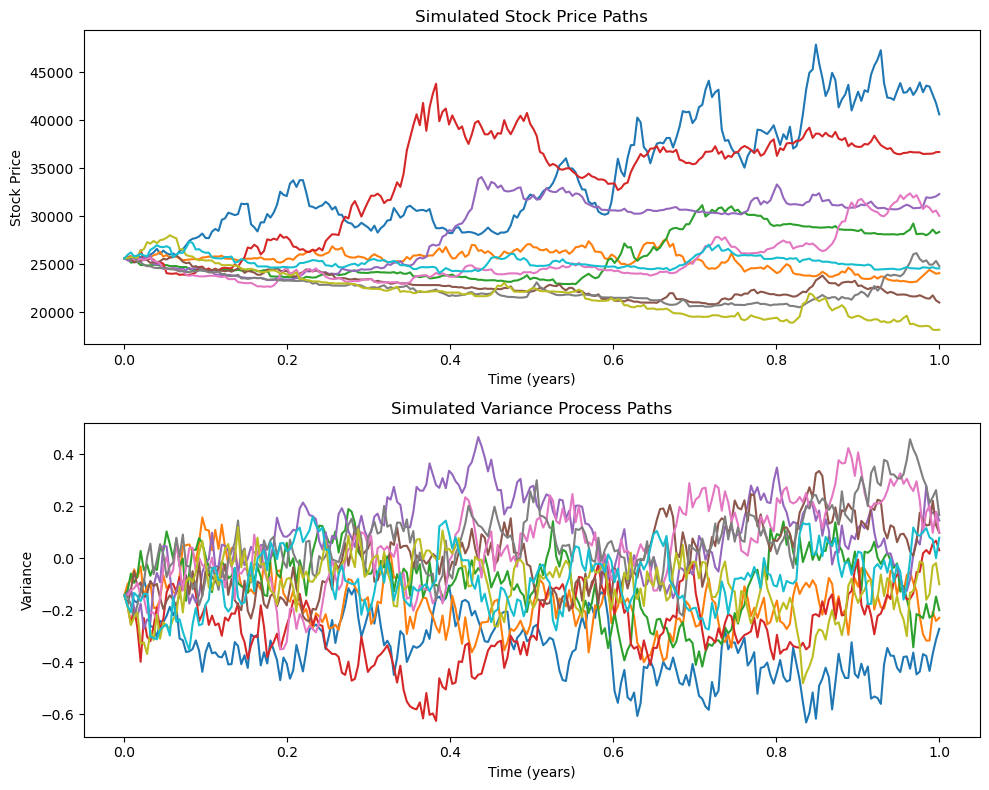

In [5]:
S0 = optiondict['HSI']
r = optiondict['rf']
T = 1.0
n_points = 252

simulator = VolterraSteinSteinSimulator(params=param)
t_grid, X_paths, S_paths = simulator.simulate_vss_path(T, S0, n_points, N_paths=10)

fig, axs = plt.subplots(2, 1, figsize=(10, 8))

for i in range(10):
    axs[0].plot(t_grid, S_paths[i])
    axs[0].set_title('Simulated Stock Price Paths')
    axs[0].set_xlabel('Time (years)')
    axs[0].set_ylabel('Stock Price')
    axs[0].grid()

    axs[1].plot(t_grid, X_paths[i])
    axs[1].set_title('Simulated Variance Process Paths')
    axs[1].set_xlabel('Time (years)')
    axs[1].set_ylabel('Variance')
    axs[1].grid()
plt.tight_layout()
plt.show()

In [6]:
pricer = VSSPricerCOS(param)
modelPrice = cal_price(pricer.get_params(False), pricer, optiondict)

tau: 0.08333333333333333, n: 32, RMSE this round: 93.27399367627186
tau: 0.15873015873015872, n: 32, RMSE this round: 84.71502650532526
tau: 0.24603174603174602, n: 32, RMSE this round: 98.87324882115352
tau: 0.32142857142857145, n: 32, RMSE this round: 91.87223549896191
tau: 0.5793650793650793, n: 36, RMSE this round: 140.9168793601439
tau: 0.8293650793650793, n: 52, RMSE this round: 289.72284588722107
tau: 1.0793650793650793, n: 68, RMSE this round: 436.8980854665073
tau: 1.3293650793650793, n: 83, RMSE this round: 441.8796849353854
tau: 1.8293650793650793, n: 115, RMSE this round: 703.5228254227067
tau: 2.3293650793650795, n: 146, RMSE this round: 786.9681151539017
tau: 3.3293650793650795, n: 209, RMSE this round: 996.9464688053159
tau: 4.329365079365079, n: 272, RMSE this round: 1293.5859451562164
tau: 5.329365079365079, n: 335, RMSE this round: 1794.8056522215445


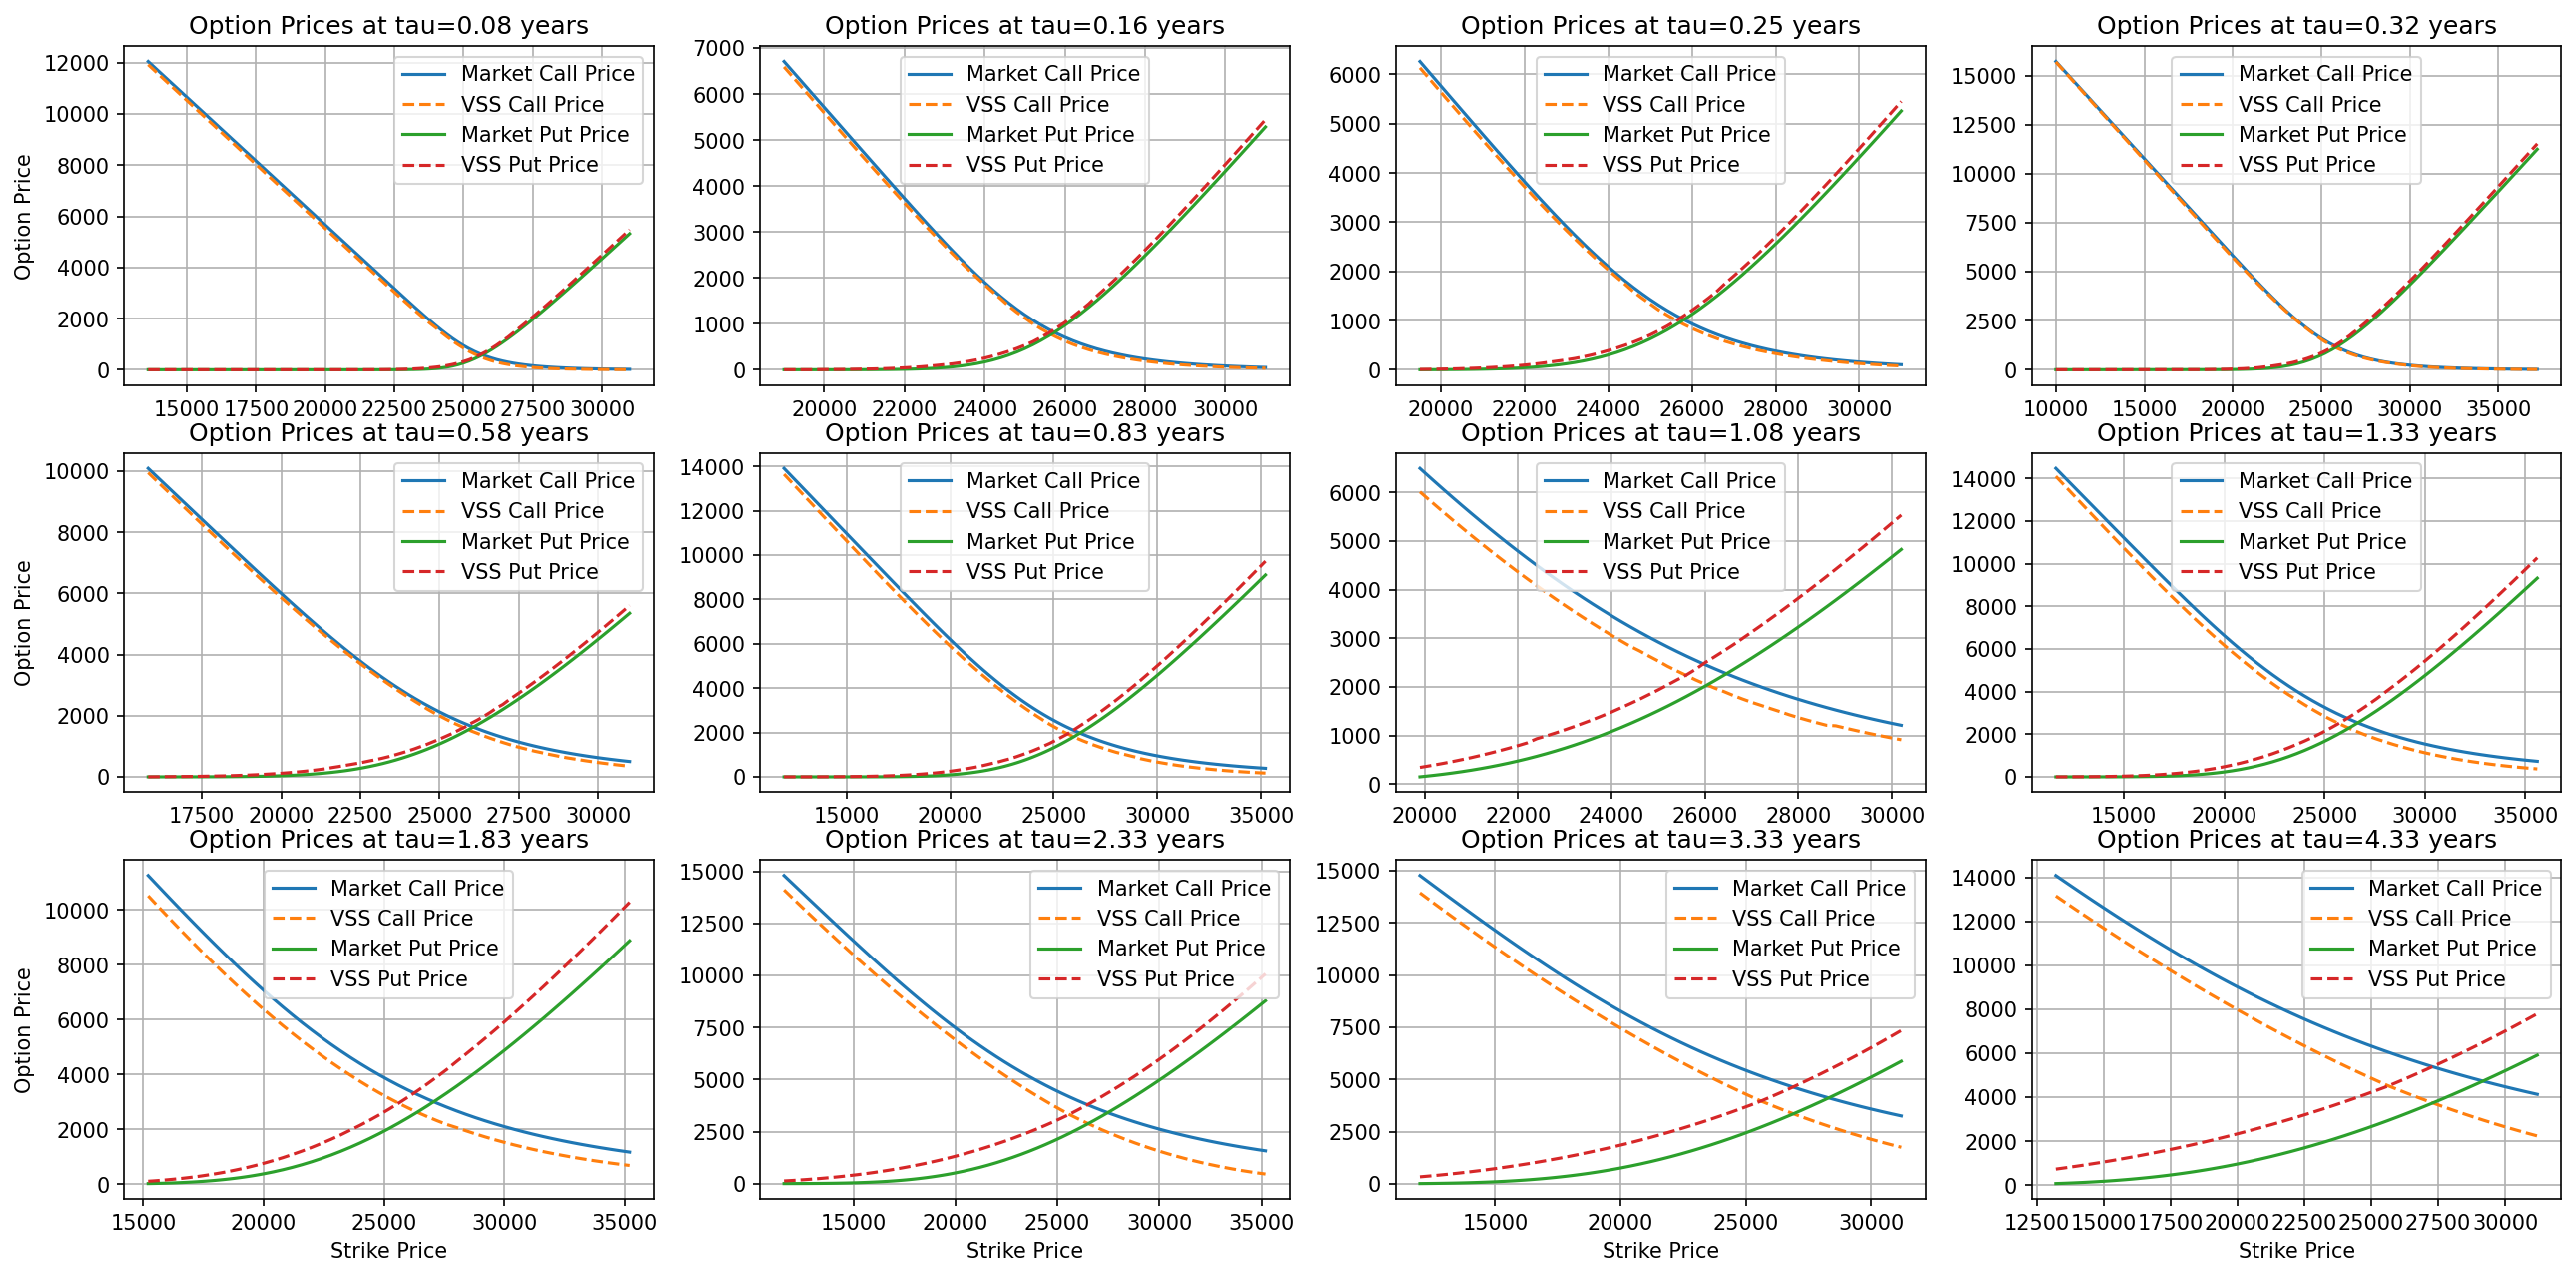

In [7]:
fig_price, axs_price = plt.subplots(3, 4, figsize=(21, 10), dpi=150)
axs_price = axs_price.flatten()
ax_idx = 0

for key, value in optiondict.items():
    if not isinstance(value, dict):
        continue
    tau = value['tau']
    if ax_idx < 12:
        axs_price[ax_idx].plot(value['strike']['call'], modelPrice[key]['call'], label='Market Call Price', linestyle='-')
        axs_price[ax_idx].plot(value['strike']['call'], value['price']['call'], label='VSS Call Price', linestyle='--')
        axs_price[ax_idx].plot(value['strike']['put'], modelPrice[key]['put'], label='Market Put Price', linestyle='-')
        axs_price[ax_idx].plot(value['strike']['put'], value['price']['put'], label='VSS Put Price', linestyle='--')

        if ax_idx in [0, 4, 8]:
            axs_price[ax_idx].set_ylabel('Option Price')
        if ax_idx >= 8:
            axs_price[ax_idx].set_xlabel('Strike Price')
        
        axs_price[ax_idx].legend()
        axs_price[ax_idx].grid()
        axs_price[ax_idx].set_title(f'Option Prices at tau={tau:.02f} years')
        ax_idx += 1
plt.show()

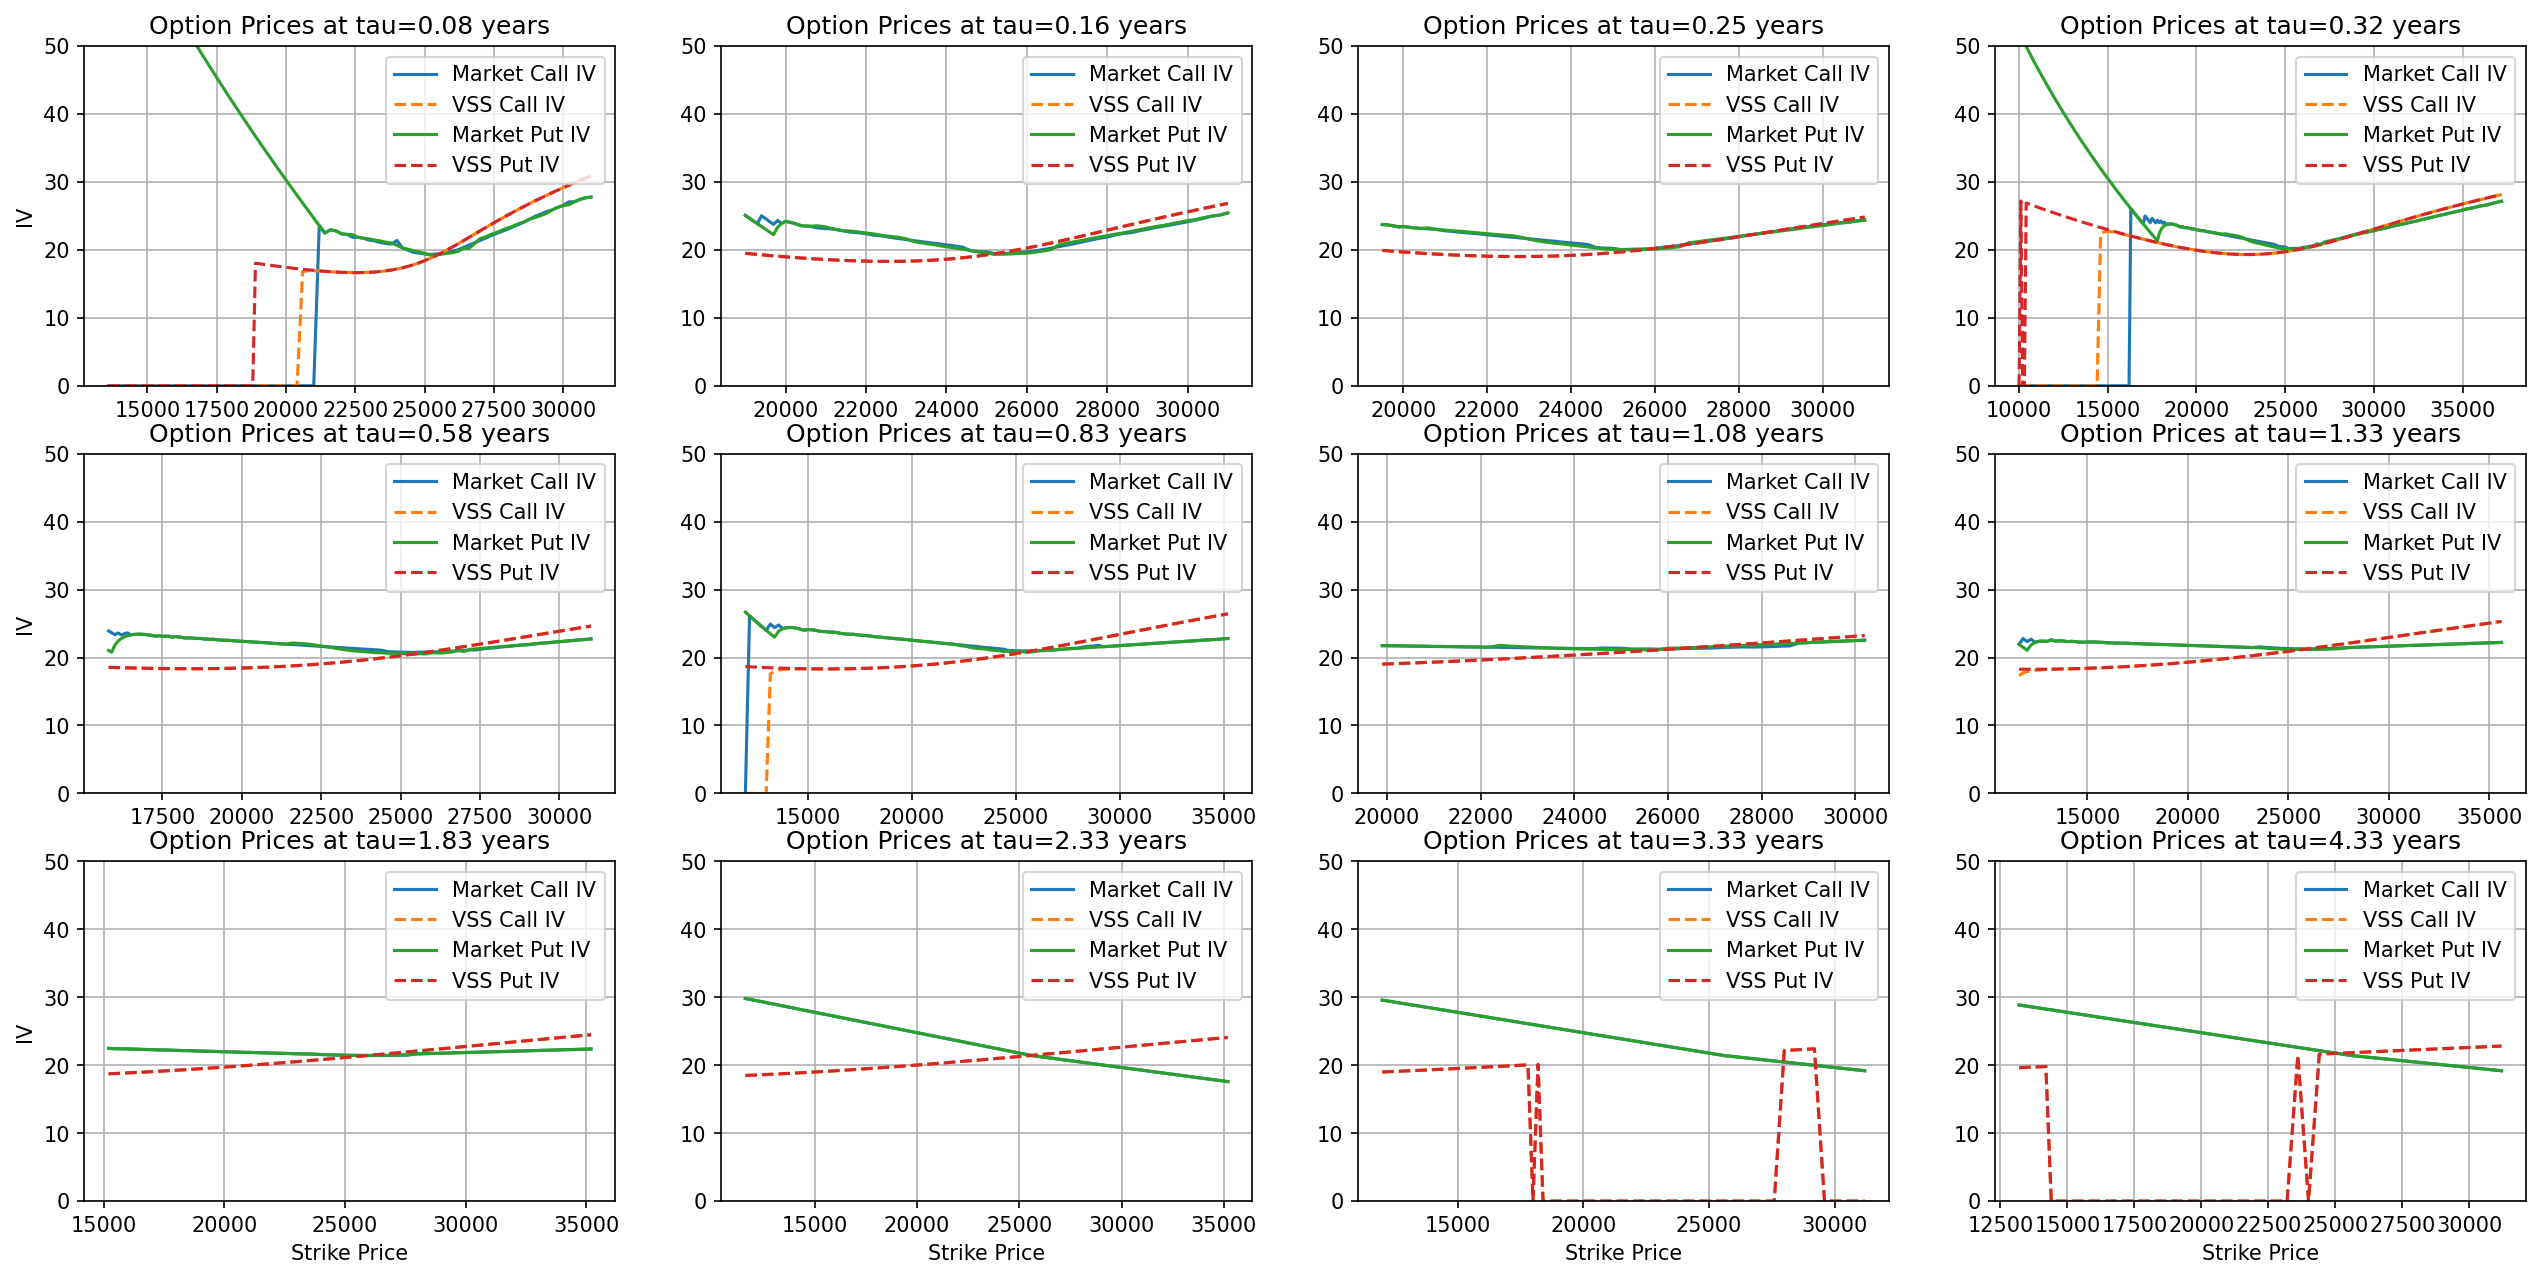

In [8]:
fig_IV, axs_IV = plt.subplots(3, 4, figsize=(21, 10), dpi=150)
axs_IV = axs_IV.flatten()
ax_idx = 0
S0 = optiondict['HSI']
rf = 0.03
for key, value in optiondict.items():
    if not isinstance(value, dict):
        continue
    tau = value['tau']
    if ax_idx < 12:
        iv_model_call = np.array([IV_newton(p, S0, K, tau, rf, 0, 'call') for K, p in zip(value['strike']['call'], modelPrice[key]['call'])])
        iv_model_put = np.array([IV_newton(p, S0, K, tau, rf, 0, 'put') for K, p in zip(value['strike']['put'], modelPrice[key]['put'])])
        iv_mkt_call = np.array([IV_newton(p, S0, K, tau, rf, 0, 'call') for K, p in zip(value['strike']['call'], value['price']['call'])])
        iv_mkt_put = np.array([IV_newton(p, S0, K, tau, rf, 0, 'put') for K, p in zip(value['strike']['put'], value['price']['put'])])

        axs_IV[ax_idx].set_ylim(0, 50)
        axs_IV[ax_idx].plot(value['strike']['call'], value['IV']['call'], label='Market Call IV', linestyle='-')
        axs_IV[ax_idx].plot(value['strike']['call'], iv_model_call * 100, label='VSS Call IV', linestyle='--')
        axs_IV[ax_idx].plot(value['strike']['put'], value['IV']['put'], label='Market Put IV', linestyle='-')
        axs_IV[ax_idx].plot(value['strike']['put'], iv_model_put * 100, label='VSS Put IV', linestyle='--')
        if ax_idx in [0, 4, 8]:
            axs_IV[ax_idx].set_ylabel('IV')
        if ax_idx >= 8:
            axs_IV[ax_idx].set_xlabel('Strike Price')
        
        axs_IV[ax_idx].legend()
        axs_IV[ax_idx].grid()
        axs_IV[ax_idx].set_title(f'Option Prices at tau={tau:.02f} years')
        ax_idx += 1
plt.show()